## Task: Solve a Binary Classification Problem Using NumPy Only

Implement a **Logistic Regression** using **Gradient Descent with L1 and L2 regularization**.

### Goal:
Achieve **Accuracy $> 0.85 $** on the provided dataset.


### Hints:
- Try different scalers.
- Experiment with **periodic** and **polynomial** features.


Clear memory

In [1625]:
%reset -f
import gc
gc.collect()

0

### Import libraries

In [1626]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time, json
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)  # количество отображаемых полей
pd.set_option('display.max_rows', None)  # количество отображаемых строк
warnings.simplefilter('ignore', category=FutureWarning)  # отключаем бесячие предупреждения
warnings.simplefilter('ignore', category=DeprecationWarning)  # отключаем бесячие предупреждения
%matplotlib inline

# Load Binary Classification dataset

In [1627]:
df = pd.read_csv('Binary_Classification_Dataset.csv', encoding='utf-8')

In [1628]:
df.head()

,x1,x2,target
0,0.362297,0.282471,1
1,-0.272077,0.235646,1
2,-0.640725,0.549436,1
3,-0.566938,0.245888,1
4,0.471062,-0.881526,0


Check the shape of the dataset

In [1629]:
df.shape

(1000, 3)

Check the main info about dataset

In [1630]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


Check some stats

In [1631]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,1000.0,-0.002987,0.583111,-1.541031,-0.447499,0.005674,0.446626,1.302505
x2,1000.0,-0.005360,0.591021,-1.462971,-0.453772,0.007523,0.447648,1.339668
target,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000


Check missing values

In [1632]:
df.isna().sum()

x1        0
x2        0
target    0
dtype: int64

There is no missing values in the dataset!

Check for percentage of duplicated samples

In [1633]:
df.duplicated().sum()/df.shape[0]*100

0.0

Check number of unique values of each variable

In [1634]:
df.nunique()

x1        1000
x2        1000
target       2
dtype: int64

The target is categorical, while all features are numerical

Define categorical and numerical features

In [1635]:
num_features = ['x1', 'x2']

Define target variable

In [1636]:
target = 'target'

## Deleting outliers

We can use standart IQR

In [1637]:
def remove_outliers(df:pd.DataFrame, numeric_features) -> pd.DataFrame:

    mask = np.ones(df.shape[0], dtype=bool)

    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask &= (df[feature] >= lower_bound) & (df[feature] <= upper_bound)

    return df.loc[mask]

Create auxiliary dataframe

In [1638]:
df_copy = df.copy()

Since target is categorical, it is better to filter outliers inside each category

In [1639]:
df = df.groupby(target, group_keys=False).apply(remove_outliers, num_features)
df = pd.DataFrame(df)  # Auxiliary action. Corrects the code highlighting issue

Check that target distribution didn't change dramatically after filtering outliers

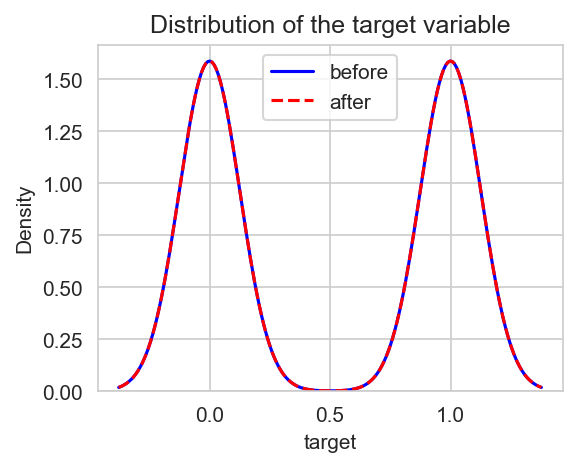

In [1640]:
plt.figure(figsize=(4,3), dpi=150)
sns.kdeplot(data=df_copy, x=target, label='before', color='blue')
sns.kdeplot(data=df, x=target, label='after', color='red', linestyle='--')
plt.legend()
plt.title('Distribution of the target variable')
plt.show()

Delete auxiliary variable to clear memory

In [1641]:
del df_copy

## EDA

### Single variable analysis

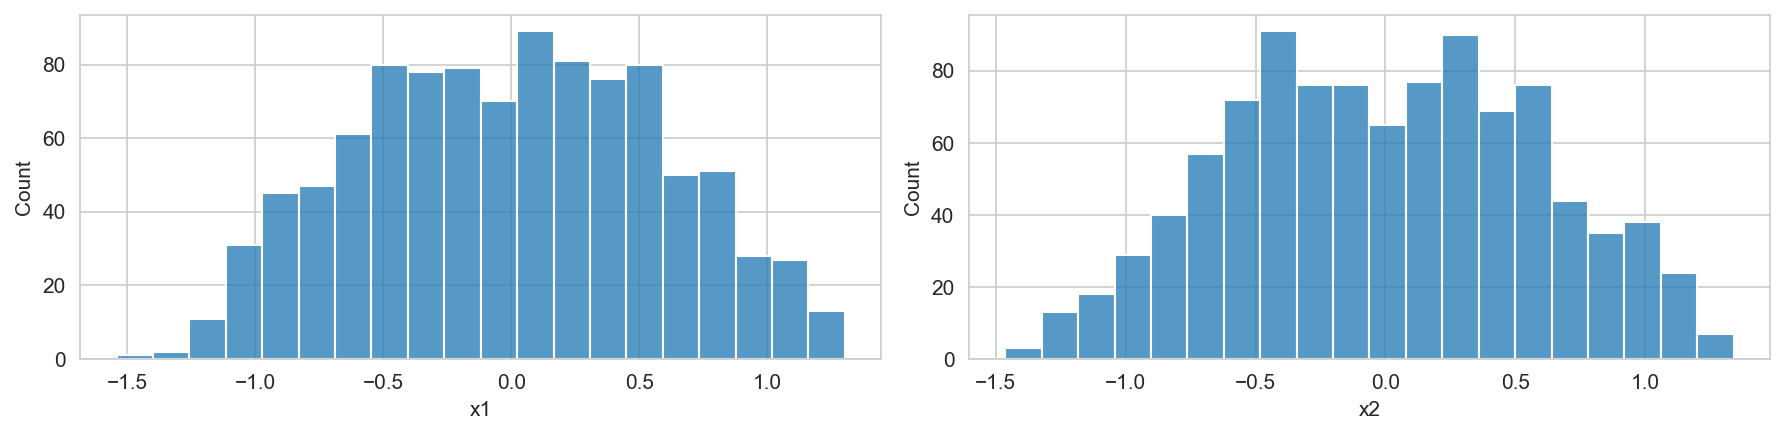

In [1642]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=f, bins=20)

plt.tight_layout()
plt.show()

**Observations**: features are normally distributed

Now, let's plot the distribution of the target

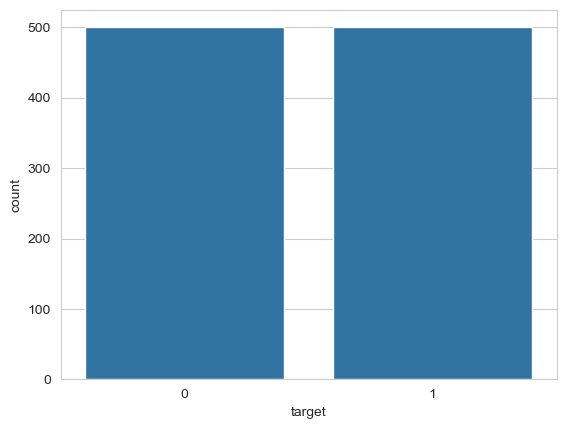

In [1643]:
sns.countplot(data=df, x=target)
plt.show()

Target classes are balanced very well

### Multivariable analysis

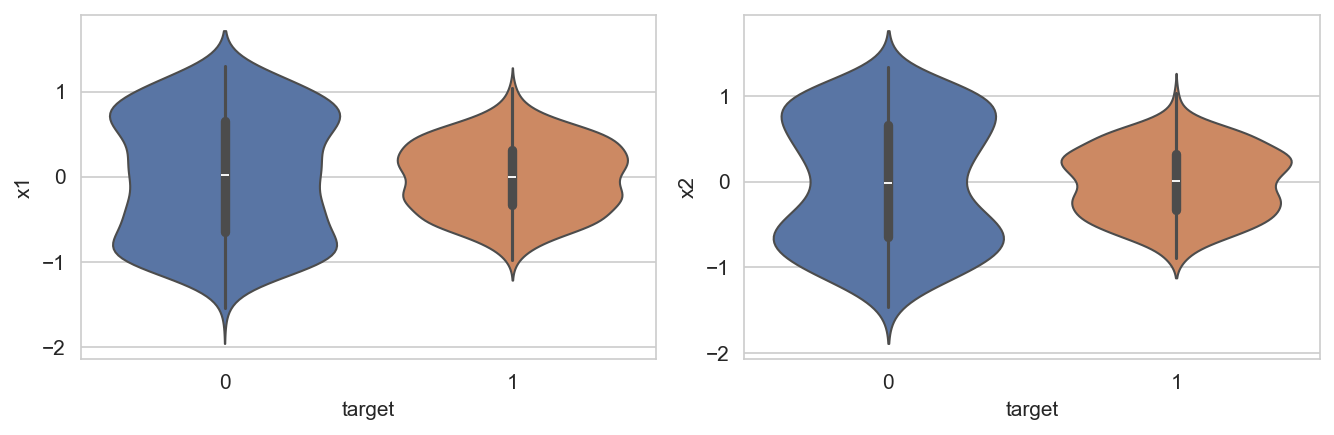

In [1644]:
plt.figure(figsize=(9,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,2,i+1)
    sns.violinplot(
        data=df,
        x=target,
        y=f,
        palette='deep',
        hue=target,
        legend=False,
        linewidth=1,
        alpha=1,
        inner='box',
        orient='v',
    )

plt.tight_layout()
plt.show()

**Observation:** class 0 has much wider distribution, then class 1.

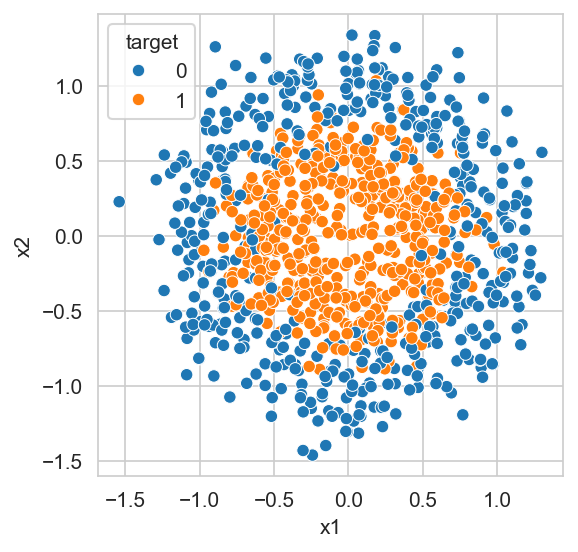

In [1645]:
plt.figure(figsize=(4,4), dpi=150)
sns.scatterplot(data=df, x='x1', y='x2', hue=target)
plt.show()

**Observation:** both classes have nonlinear (squared) dependencies with the target.

### Correlation matrix

In [1646]:
def correlation_heatmap(df:pd.DataFrame) -> None:
    sns.heatmap(
        data=df.corr().abs(),
        cmap='magma',
        annot=True,
        fmt='.1f',
        annot_kws={'size': 8},
        vmax=1,
        vmin=0,
    )
    plt.title('Correlation matrix')

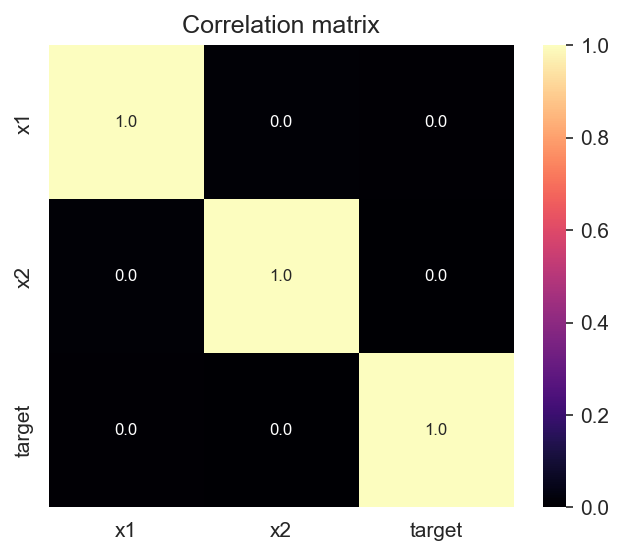

In [1647]:
plt.figure(figsize=(5,4), dpi=150)
correlation_heatmap(df.copy())
plt.show()

**Observation:** features do not have linear correlation with the target.

### Mutual information

In [1648]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

def mutual_info_target(df:pd.DataFrame, target:str) -> None:

    X = df.loc[:, df.columns != target]
    y = df[target]

    if y.dtype == int:
        mi_scores = pd.Series(mutual_info_classif(X, y), index=X.columns)
    else:
        mi_scores = pd.Series(mutual_info_regression(X, y), index=X.columns)

    sns.barplot(mi_scores.sort_values(ascending=False), palette='deep')
    plt.title(f'Mutual information for {target}')
    # plt.xticks(rotation=45)


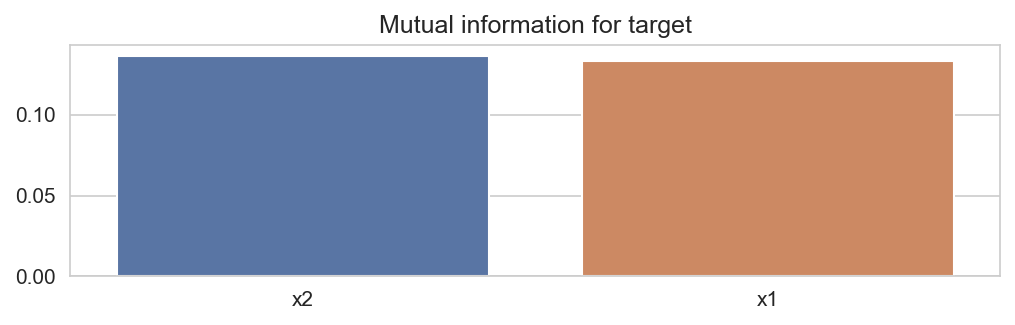

In [1649]:
plt.figure(figsize=(8,2), dpi=150)
mutual_info_target(df.copy(), target)
plt.show()

**Observation:** both features have similar MI with the target.

# Feature engineering

Split the data into X and y

In [1650]:
X = df.drop(columns=target)
y = df[target].copy()

Split the data into train and test datasets

In [1651]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

Plot the data

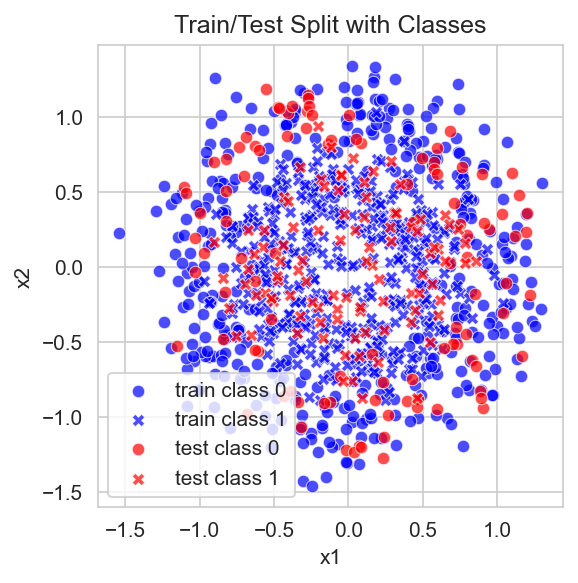

In [1652]:
plt.figure(figsize=(4, 4), dpi=150)

sns.scatterplot(data=X_train[y_train == 0], x='x1', y='x2', alpha=0.7,
                color='blue', marker='o', label='train class 0')
sns.scatterplot(data=X_train[y_train == 1], x='x1', y='x2', alpha=0.7,
                color='blue', marker='X', label='train class 1')

sns.scatterplot(data=X_test[y_test == 0], x='x1', y='x2', alpha=0.7,
                color='red', marker='o', label='test class 0')
sns.scatterplot(data=X_test[y_test == 1], x='x1', y='x2', alpha=0.7,
                color='red', marker='X', label='test class 1')

plt.legend()
plt.title('Train/Test Split with Classes')
plt.show()


### Add some new features

In [1653]:
X_train['x1_squared'] = X_train['x1'] ** 2
X_test['x1_squared'] = X_test['x1'] ** 2

X_train['x2_squared'] = X_train['x2'] ** 2
X_test['x2_squared'] = X_test['x2'] ** 2

X_train['r'] = np.sqrt(X_train['x1']**2 + X_train['x2']**2)
X_test['r'] = np.sqrt(X_test['x1']**2 + X_test['x2']**2)

Update the numerical feature list

In [1654]:
num_features = ['x1', 'x2', 'x1_squared', 'x2_squared', 'r']

### Feature scaling

In [1655]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

Convert the data

In [1656]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Modeling

## Logistic regression using gradient descend

Initialize weights and a bias

In [1657]:
W_g = np.ones((X_train.shape[1], 1))
b_g = 1

Use sigmoid function

In [1658]:
def sigmoid(F:np.ndarray) -> np.ndarray:
    Z = np.power(np.exp(-F)+1, -1)
    return Z

Predict the target (forward pass)

In [1659]:
def forward_pass(X:np.ndarray, W:np.ndarray, b:np.ndarray=None) -> np.ndarray:
    if b is None:
        y = sigmoid(X@W)
    else:
        y = sigmoid(X@W + b)
    return y.squeeze()

Compute Loss function

In [1660]:
def loss_function(y_hat:np.ndarray, y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0) -> float:
    l = -(1/len(y_hat)) * np.sum(y_true * np.log(y_hat + 1e-15) + (1 - y_true) * np.log(1 - y_hat + 1e-15))
    if W is not None:
        l += r1 * np.sum(np.power(W,2))/len(W)
        l += r2 * np.sum(np.abs(W))/(len(W)*2)
    return l

Compute gradients

In [ ]:
def gradients(X:np.ndarray, y_hat:np.ndarray, y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0):
    gW = (X.T @ (y_hat - y_true).reshape((len(y_true), 1)))/X.shape[0]
    gb = np.sum(y_hat - y_true)/X.shape[0]
    if W is not None:
        gW += r1 * np.sign(W)
        gW += r2 * W
    return gW, gb

Update weights and the bias

In [1662]:
def update_weights(W:np.ndarray,  gW:np.ndarray,  b:float, gb:float, lr:float=0.01):
    W -= lr*gW
    b -= lr*gb
    return W, b

Loop

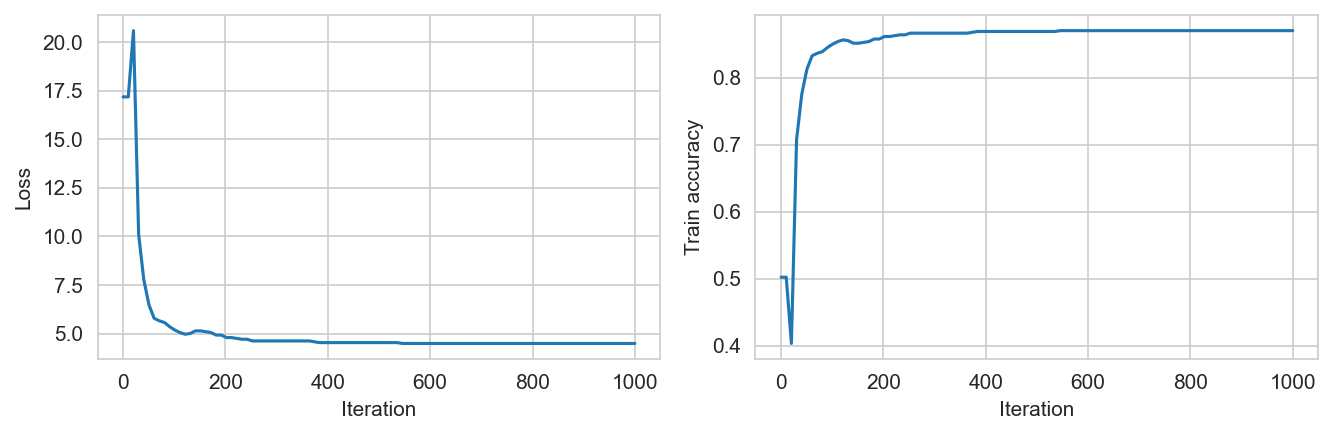

In [1663]:
epochs = 1000
r1, r2 = 0.0001, 0.001
lr0 = 0.5
decay_rate = 0.001
progress = []
score = []

for epoch in range(epochs):
    y_pred_g = forward_pass(X_train, W_g, b_g)
    gradW, gradb = gradients(X_train, y_pred_g, y_train, W_g, r1, r2)
    lr = lr0 / (1 + decay_rate * epoch)
    W_g, b_g = update_weights(W_g, gradW, b_g, gradb, lr)
    if epoch%10 == 0:
        y_pred_g = (y_pred_g > 0.5).astype(int)
        score.append(np.mean(y_pred_g == y_train))
        progress.append(loss_function(y_pred_g, y_train, W_g, r1, r2))

plt.figure(figsize=(9,3), dpi=150)
plt.subplot(1,2,1)
plt.plot(np.linspace(0, epochs, len(progress)), progress)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(np.linspace(0, epochs, len(score)), score)
plt.xlabel('Iteration')
plt.ylabel('Train accuracy')
plt.tight_layout()
plt.show()

Make final prediction

In [1664]:
y_pred_g = forward_pass(X_test, W_g, b_g)
y_pred_g = (y_pred_g > 0.5).astype(int)

## Evaluate results

Evaluate result using accuracy

In [1665]:
acc_g = np.mean(y_pred_g == y_test)

print('Accuracy using gradient descend:', round(acc_g, 3))

Accuracy using gradient descend: 0.88
